# Lab 3 (Part A): Classification with logistic regression

<div class="alert alert-block alert-danger">

__IMPORTANT__ 
Please complete this Jupyter Notebook file and upload it to blackboard __before 13 February 2020__.
</div>

In this Lab, you will start by implementing logistic regression (for classification) and apply it to a dataset. Before starting, make sure that you read the slides of lecture 3.

Your task in the first part of this Lab will be to build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision. You will build a classification model that estimates an applicant's probability of admission based on the scores from those two exams.

## Loading the data
We have a file `university-admission-dataset.csv` which contains the dataset for our classification problem. The first column is the score obtained at exam1, the second column is the score obtained at exam2, and the third column is the class-label indicating if the student has been admitted or not (1 = Admitted, 0 = Not admitted).

<img src="imgs/UnivAdmDataLab3A.png" />

The following Python code helps you load the dataset from the csv file into the variables $X$ and $y$. The variable $X$ is the input data, which is a matrix with two columns (two feature) corresponding to the score at exam1 and the score at exam2. The variable $y$ is the output class-labels corresponding to whether or not each student has been admitted. Read the following code and print a small subset of $X$ and $y$ to see what they look like.


In [57]:
%matplotlib notebook
import numpy as np

# Loading the data from the file into mydata
filename = "datasets/university-admission-dataset.csv"
mydata = np.genfromtxt(filename, delimiter=",")

# We have n students (each line corresponds to one student)
n = len(mydata)

# We take the two first columns from mydata. So, X is a matrix of n lines and two 
# columns ("score at exam1" and "score at exam2"), i.e. an array of n 2-dimensional data-points
X = mydata[:, :2]

# We take the class-labels from mydata (-1 refers to the last column)
# So, y is the vector of outputs, i.e. an array of n scalar values
y = mydata[:, -1]

""" TODO:
You can print here a small subset of X and y (e.g. corresponding to 10 students) to see what they look like.
"""
print(X[:5])
print(y[:5])

[[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
[0. 0. 0. 1. 1.]


## Visualizing the data
Before starting to implement any learning algorithm, it is always good to visualize the data if possible. Complete the following Python code so that it displays a figure like the one shown below. The axes are the two exam scores (i.e. our features), and the class-labels are shown with different markers/colors.
<img src="imgs/UnivAdmScatterPlotLab3A.png" width="500px" />

**Practical hint:**
Suppose that we have two numpy arrays `a` and `b` of the same length, as in the following example:
```python
a = np.array(["This", "is", "an", "interesting", "example"])
b = np.array(["yes", "yes", "no", "yes", "no"])
```
If we write `b == "yes"`, this will produce a boolean array: `[True, True, False, True, False]`. This array contains `True` if the corresponding value in `b` is `"yes"`, and `"False"` otherwise. Similarly, `b == "no"` will produce the boolean array `[False, False,  True, False,  True]`. Moreover, given an array of boolean values, e.g. `arr = [True,  True, False,  True, False]`, if we write `a[arr]` then we get `["This", "is", "interesting"]`. This corresponds to the elements of `a` where the corresponding value in `arr` was `True`. In summary, to get the elements of a where the corresponding value in b is "yes", we can simply use `a[b == "yes"]`.
```python
print( a[b == "yes"] ) # This gives: ["This", "is", "interesting"]
print( a[b == "no"] ) # This gives: ["an", "example"]
```
You can use this syntax to select a subset of data-points (from $X$) which have a given label (in $y$).

<IPython.core.display.Javascript object>


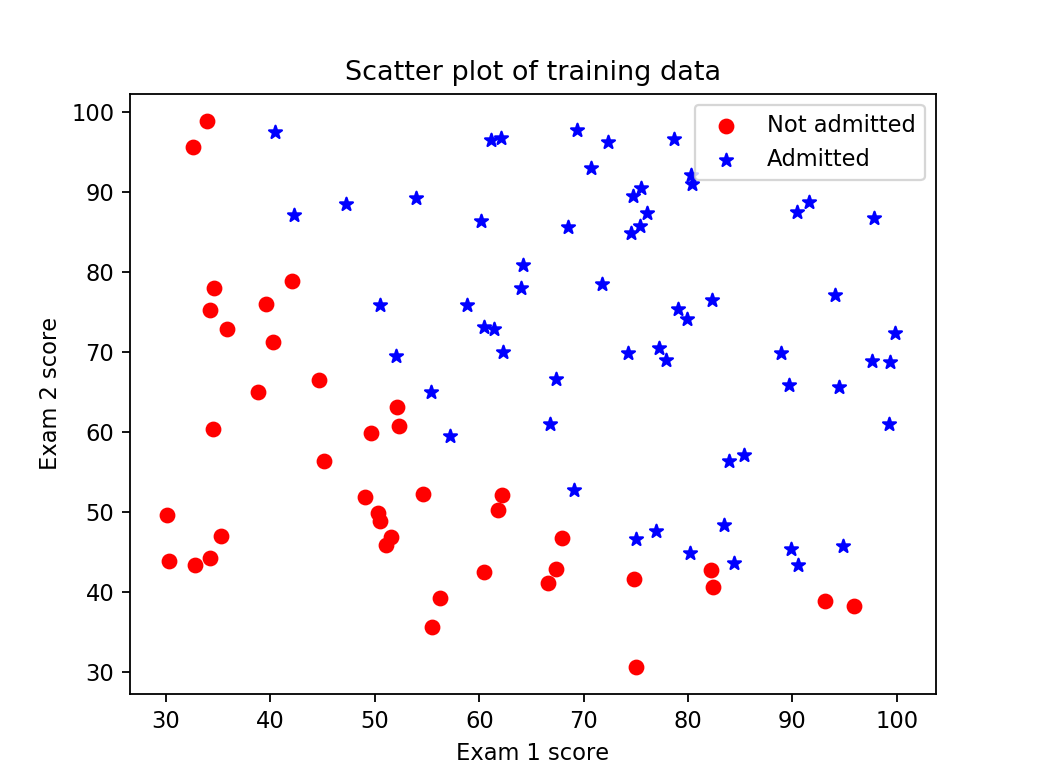

In [58]:
import matplotlib.pylab as plt

""" TODO:
Follow the steps below to complete the code and produce a scatter 
plot of the training data like the one shown in the figure above.
"""

# TODO: select the data-points from X whose corresponding class-label is 0 (not admitted).
# X0 = ...
X0 = X[y == 0]
# TODO: select the data-points from X whose corresponding class-label is 1 (admitted).
# X1 = ...
X1 = X[y == 1]

fig, ax = plt.subplots()
# TODO: scatter plot for the non admitted students (X0)
ax.scatter(X0[:,0],X0[:,1], color= "red",marker="o",label="Not admitted")
# TODO: scatter plot for the admitted students (X1)
ax.scatter(X1[:,0],X1[:,1],color = "blue", marker="*", label="Admitted")
# TODO: set the 1st axis label to "Exam 1 score"
ax.set_xlabel("Exam 1 score")
# TODO: set the 2nd axis label to "Exam 2 score"
ax.set_ylabel("Exam 2 score")
# TODO: set the title to "Scatter plot of training data"
ax.set_title("Scatter plot of training data")
plt.legend()
fig.show()


## Adding a first column of ones to the dataset
Before starting the implementation of logistic regression, it might be helpful to use a modified version of our dataset which has an additional first column of ones.

In [59]:
# This function takes a matrix as argument and returns a new matrix with an additional first column (of ones)
def add_all_ones_column(X):
    n, d = X.shape # dimension of the matrix X (n lines, d columns)
    XX = np.ones((n, d+1)) # new matrix of all ones with one additional column
    XX[:, 1:] = X # set X starting from column 1 (keep only column 0 unchanged)
    return XX

# The following line creates a new data matrix X_new with an additional first column (of ones)
X_new = add_all_ones_column(X)

""" TODO:
You can print a small subset of X_new here to see how it looks like 
"""
print(X_new[:5])

[[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]]


## Sigmoid function
Before you start implementing the actual cost function, recall that the logistic regression hypothesis is defined as:
$$h_\theta(x) = g(\theta^T x),$$
where function $g$ is the `sigmoid` function, defined as:
$$g(z) = \frac{1}{1 + e^{-z}}$$

Your first step is to complete the code below to implement this function so it can be called by the rest of your program. When you are finished, try testing a few values by calling `sigmoid(z)`. For large positive values of x, the sigmoid should be close to $1$, while for large negative values, the sigmoid should be close to $0$. Evaluating `sigmoid(0)` should give you exactly $0.5$. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid function on every element. You can use the numpy function `np.exp(..)` to compute the exponancial. This later works on scalar values, vectors as well as matricies.

In [60]:
""" TODO:
Write code for the definition of the sigmoid function. This function 
should work on a scalar value as well as a vector or a matrix.
"""
def sigmoid(z):
    return pow(1 + np.exp(-z), -1)


""" TODO:
Test your sigmoid function by calling it few times on some scalar values, a vector, and then matrix.
"""



# The hypothesis function is defined as follows:
def h(theta, x):
    return sigmoid(theta.T @ x)



""" TODO (OPTIONAL):
The above hypothesis function h(theta, x) makes a prediction for only one data-point x.
Write here a modified function h_all(theta, X) which gives predictions for a dataset.
"""
def h_all(theta, X): # notice the usage of big capital X here (refering to a dataset)

    return sigmoid(X @ theta.T) 



## Cost function and gradient
Now you will implement the cost function and gradient for logistic regression. Recall that the cost function in logistic regression is:
$$E(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left [ -y^{(i)} \log{(h_\theta(x^{(i)}))} - (1 - y^{(i)}) \log{(1 - h_\theta(x^{(i)}))} \right ]$$

and the gradient of the cost, $\nabla E(\theta)$, is a vector of the same length as $\theta$ defined as:

$$
\nabla E(\theta) = \left ( \frac{\partial E(\theta)}{\partial \theta_0}, \frac{\partial E(\theta)}{\partial \theta_1}, \frac{\partial E(\theta)}{\partial \theta_2}, \dots \right )
\quad \quad \text{ where the $j^{th}$ element }
\frac{\partial E(\theta)}{\partial \theta_j} = \frac{1}{n} \sum_{i=1}^{n} \left [ h_{\theta}(x^{(i)}) - y^{(i)} \right ] ~ x^{(i)}_j
$$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

Complete the Python code below to return the cost and gradient. You can use `np.log(..)` to compute the $\log$. Once you implement the cost function $E$ correctly, calling it with an initial $\theta$ of zeros should return a cost of about $0.693$.

In [61]:
""" TODO:
Write code for the definition of the cost function. If possible, try to implement 
it in a vectorized form (by manipulating arrays directly without using a loop). If 
you are not able to implement it in a vectorized form, then it's fine to use a loop.
"""
def E(theta, X, y):
    return  (1/len(X)) * ((-1)*y @ np.log(h_all(theta,X)) - (1 - y) @ np.log(1 - h_all(theta,X)))

""" TODO:
Call your cost function here to test it using an initial theta of all zeros, and 
using X_new (instead of X). Calling E(theta, X_new, y) should return about 0.693.
"""
theta = np.array([0, 0, 0])
print( E(theta, X_new, y) )


""" TODO:
Write the definition of the gradient function. It should return an array containing 
the derivative of the cost function with respect to each parameter theta[j].
"""
def gradE(theta, X, y):
    return (1/len(X)) * (h_all(theta,X) - y) @ X


0.693147180559945


## Learning parameters using scipy.optimize.minimize

In the previous Lab, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use a Python function predefined in the `scipy` library: `scipy.optimize.minimize(..)`. This function is an optimization solver that finds the minimum of a given function. For logistic regression, you want to optimize the cost function $E(\theta)$ with parameters $\theta$.

Concretely, you are going to use `scipy.optimize.minimize(..)` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (`X_new` and `y` values). You will pass to `scipy.optimize.minimize(..)` the following arguments (in that order) :

- Name of the cost function to be minimized. In our case, it's just `E`
- Array of initial parameter values $\theta$. In our case, `theta`.
- Tuple of extra arguments (in addition to $\theta$) passed to the cost function and the gradient function. In our case, it's `(X_new, y)`
- String corresponding to type of the optimization solver. Here you can use `"TNC"` which refers to *Truncated Newton algorithm*.
- Name of the function that computes the gradient vector. In our case, it's just `gradE`.

`scipy.optimize.minimize(..)` returns an object containing the optimization results. The most important attribute of this object is called `x` and represent the optimal solution array (i.e. the best $\theta$). So, once you call `res = scipy.optimize.minimize(..)`, you can get the optimal $\theta$ simply using `res.x`.

For more information about `scipy.optimize.minimize(..)`, you can visit:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
- https://docs.scipy.org/doc/scipy/reference/optimize.html

Complete the Python code below to find the optimal parameter vector $\theta$ for logistic regression.

Notice that by using `scipy.optimize.minimize(..)`, you do not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `scipy.optimize.minimize(..)`: you only needed to provide a function calculating the cost and the gradient. Once `scipy.optimize.minimize(..)` completes, calling the cost function function using the optimal parameters of $\theta$  should give you a cost of about $0.203$.

In [62]:
import scipy.optimize as op

theta = np.array([0, 0, 0])  # Some initial parameters vector
print("Initial cost: ", E(theta, X_new, y))


""" TODO:
Use op.minimize(..) with the right arguments (as explained above) in order 
to minimize the cost function E. Then, print the optimal parameter vector theta and the final cost.
"""
res = op.minimize(E, theta , (X_new,y) , "TNC", gradE)
theta = res.x
print("Optimal parameters: {}\nFinal cost: {}".format(theta,E(theta,X_new,y)))
# Then, the optimal parameters can be accessed with: theta = res.x
# print(...) # the best parameters and their corresponding cost


Initial cost:  0.693147180559945
Optimal parameters: [-25.1613185    0.20623159   0.20147148]
Final cost: 0.20349770158947508


## Plotting the decision boundary
One you get the optimal parameters of $\theta$, you can call the function `plot_decision_boundary(X, y, theta)` defined in the code below to plot the original dataset and the decision boundary. Read the code carefully to see how such a boundary is ploted using the $\theta$ values. Basically, the equation of our decision boundary is: $\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$. So, to plot it, we generate a range of values for $x_1$ and we compute the corresponding values of $x_2 = - \frac{\theta_0 + \theta_1 x_1}{\theta_2}$.

You are supposed to get a plot that looks like the following figure:
<img src="imgs/UnivAdmScatterPlotLab3AwithDB.png" width="500px" />


<IPython.core.display.Javascript object>


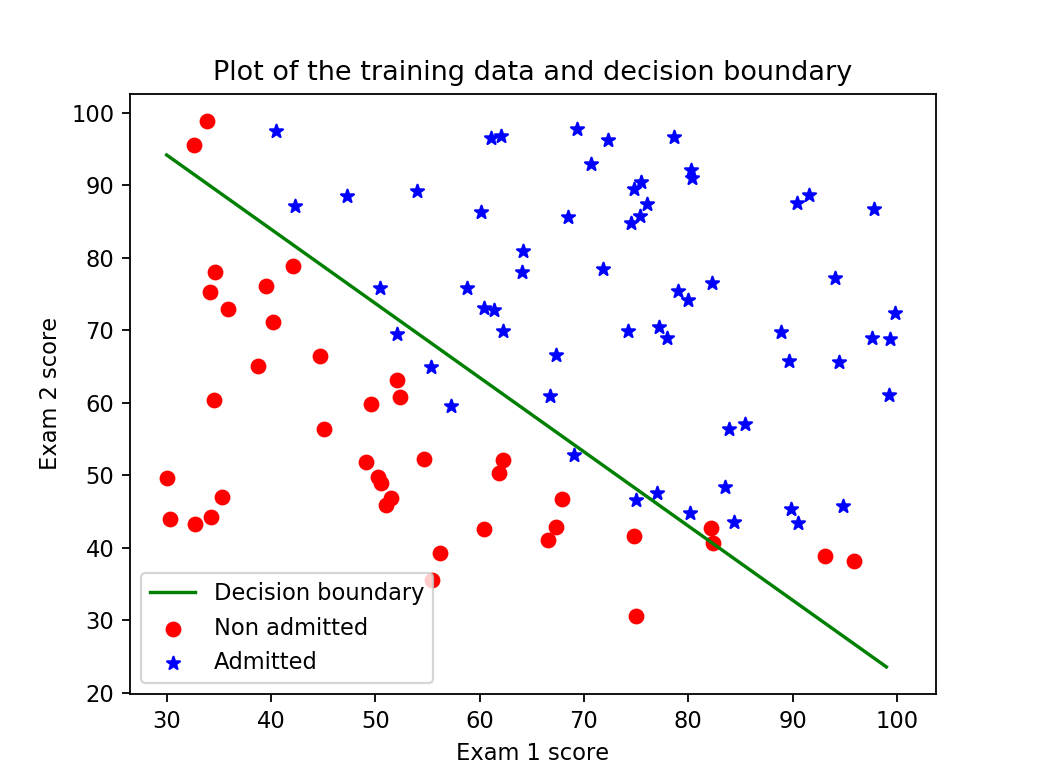

In [63]:
# This is a function that plots the original dataset (X, y) and decision boundary:
def plot_decision_boundary(X, y, theta):
    X0 = X[y==0] # subset of the non admitted students
    X1 = X[y==1] # subset of the admitted students
    
    fig, ax = plt.subplots()
    
    # Plottin the dataset:
    ax.scatter(X0[:, 0], X0[:, 1], marker="o", color="red", label="Non admitted")
    ax.scatter(X1[:, 0], X1[:, 1], marker="*", color="blue", label="Admitted")
    ax.set_xlabel("Exam 1 score")
    ax.set_ylabel("Exam 2 score")
    
    # Plotting the decision boundary:
    plot_x1 = np.arange(30, 100) # range of values from 30 to 100
    plot_x2 = - (theta[0] + theta[1] * plot_x1) / theta[2]
    ax.plot(plot_x1, plot_x2, color="green", label="Decision boundary")
    
    ax.set_title("Plot of the training data and decision boundary")
    plt.legend()
    fig.show()


""" TODO:
Call the function plot_decision_boundary(X, y, theta) with 
the optimal theta parameters that you got previously.
"""

plot_decision_boundary(X,y,theta)

## Evaluating the logistic regression model
After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of $45$ and an Exam 2 score of $85$, you should expect to see an admission probability of about $0.776$.

In [64]:
# Student with an Exam 1 score of 45 and an Exam 2 score of 85
x = np.array([1, 45, 85])

""" TODO:
Predict the admission probability of student x, by calling the hypothesis 
function with x and the optimal parameters theta. You should expect to get 
an admission probability of about 0.776 for this student x.
"""
print("Admission probability of this student x is :{}".format(round(h(theta,x),3)))

Admission probability of this student x is :0.776


One way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the Python code below (read the *TODO* comments carefully). The `predict` function should produce an array of "$1$" or "$0$" predictions given a dataset and a learned parameters vector $\theta$. After you have completed the implementation of the `predict` function, you are asked to report the training accuracy of your classifier by computing the percentage of examples for which you correctly predicted the class-label.

*Note*: We will see later in the course that computing the ***training** accuracy* is NOT a good way to evaluate the quality of your machine learning model.

In [65]:
""" TODO:
Write the definition of the function predict(theta, X) which returns an array of 
predictions. Each prediction corresponds to a data-point x and is either 1 or 0, 
depending on whether or not the admission probability h(theta, x) is higher than 0.5.
"""
def predict(theta, X):
    return np.array(list(map(int, h_all(theta,X) > 0.5)))


""" TODO:
Predict the class-labels of the data-points in the training set by calling the function 
predict(..) with the optimal parameters vector theta and X_new. Then, compute the classification 
accuracy by comparing the predicted class-labels with the actual (true) class-labels y.
"""
y_pred = predict(theta,X_new)
accuracy = sum(y == y_pred)/len(y)
print("Accuracy", accuracy)

Accuracy 0.89
